**Imports**

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

**Data Processing and Cleaning**

In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
# Define dataset columns and load the data
DATASET_COLUMNS = ["Political Affiliation", "User @", "Tweet"]
directory = '/content/gdrive/My Drive/Colab Notebooks/APS360/Final Project/'
df = pd.read_csv(directory + 'final 5000.csv', names=DATASET_COLUMNS, header=0)
df2 = pd.read_csv(directory +'new 200.csv', names=DATASET_COLUMNS, header=0)

# Links to be removed
url_pattern = re.compile(r'https?://\S+|www\.\S+')

# Punctuation to be removed
english_punctuations = string.punctuation + '’' + '"' + '”' + '“' + "–" + "—"

def clean_data(data, colname):
    # Make all text lowercase
    data_holder = data[colname].str.lower()
    tweet = []
    # Remove empty items and split tweet text
    for i in data_holder:
        if type(i) == str: tweet.append(i.split())
    #remove hashtags and links
    for i in range(len(tweet)):
        lst = []
        for j in range(len(tweet[i])):
            if tweet[i][j][0] != "@" and tweet[i][j][0] != '#':
                lst.append(url_pattern.sub("", tweet[i][j]))
        tweet[i] = lst
    # Remove all punctuation and numbers
    for i in range(len(tweet)):
        for j in range(len(tweet[i])):
            for k in english_punctuations:
                tweet[i][j] = tweet[i][j].replace(k, "")
            tweet[i][j] = ''.join([char for char in tweet[i][j] if not char.isdigit()])
    # Remove all stop words
    stop_words = stopwords.words('english')
    for i in range(len(stop_words)):
        for k in english_punctuations:
            stop_words[i] = stop_words[i].replace(k, "")
    for i in range(len(tweet)):
        tweet[i] = [j for j in tweet[i] if j not in stop_words]
    # Apply stemming and lemmatizer
    st = nltk.PorterStemmer()
    lm = nltk.WordNetLemmatizer()
    for i in range(len(tweet)):
        tweet[i] = [st.stem(word) for word in tweet[i]]
        tweet[i] = [lm.lemmatize(word) for word in tweet[i]]
    # Remove ''
    for i in range(len(tweet)):
        tweet[i] = [j for j in tweet[i] if j not in stop_words]
        tweet[i] = [j for j in tweet[i] if (j != '' and j not in english_punctuations)]
    return [' '.join(t) for t in tweet]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**baseline model**

In [ ]:
# Clean the tweets
df['cleaned_tweet'] = clean_data(df, "Tweet")

# Remove any rows where 'cleaned_tweet' is empty
df = df[df['cleaned_tweet'].str.strip().astype(bool)]

# Split the data into features and labels
X = df['cleaned_tweet']
y = df['Political Affiliation']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert text data to a matrix of token counts
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the model
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy:.4f}')
print(report)


Accuracy: 0.8020
              precision    recall  f1-score   support

    Democrat       0.80      0.83      0.81       514
  Republican       0.81      0.77      0.79       471

    accuracy                           0.80       985
   macro avg       0.80      0.80      0.80       985
weighted avg       0.80      0.80      0.80       985



**primary model**

In [ ]:
pip install tensorflow

In [ ]:
# Training tweets, posted before Aug 3rd
t = [i for i in clean_data(df, "Tweet") if len(i) != 0]
#New tweets posted after Aug 3rd
t2 = [i for i in clean_data(df2, "Tweet") if len(i) != 0]
# Combining tweets into one dataset to tokenize
cleaned_tweets = clean_data(df, "Tweet") + clean_data(df2, "Tweet")
pol_aff = list(df['Political Affiliation']) + list(df2['Political Affiliation'])
cleaned_data = pd.DataFrame({'cleaned_tweet': cleaned_tweets, 'Political Affiliation': pol_aff})
# Remove any rows where 'cleaned_tweet' is empty
cleaned_data = cleaned_data[cleaned_data['cleaned_tweet'].str.strip().astype(bool)]
# Split the data into features and labels
X = cleaned_data['cleaned_tweet']
y = cleaned_data['Political Affiliation']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input size
max_length = 150
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data into training and testing sets, none of the new tweets are included
X_train, X_test, y_train, y_test = train_test_split(X_padded[0:len(t)], y_encoded[0:len(t)], test_size=0.2, random_state=42)

# Define the model
embedding_dim = 128
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    layers.GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Print the model summary
model.summary()

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 625ms/step - accuracy: 0.5085 - loss: 0.7000 - val_accuracy: 0.7348 - val_loss: 0.5440
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 70s 509ms/step - accuracy: 0.8261 - loss: 0.4243 - val_accuracy: 0.8122 - val_loss: 0.4365
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 474ms/step - accuracy: 0.9599 - loss: 0.1393 - val_accuracy: 0.8020 - val_loss: 0.6223
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - accuracy: 0.9876 - loss: 0.0497 - val_accuracy: 0.7919 - val_loss: 0.6386
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 486ms/step - accuracy: 0.9916 - loss: 0.0298 - val_accuracy: 0.7906 - val_loss: 0.8385
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8092 - loss: 0.4123
Accuracy: 0.7980


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step
Accuracy: 0.7677


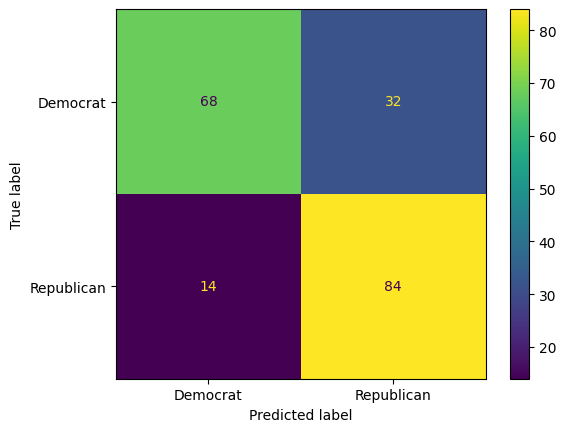

In [ ]:
#Get confusion matrix for new tweets
pred = model.predict(X_padded[len(t):len(t)+len(t2)])
pred = np.rint(pred)
# Get accuracy of tweets posted after Aug 3rd
accuracy = accuracy_score(y_encoded[len(t):len(t)+len(t2)], pred)
print(f'Accuracy: {accuracy:.4f}')
conf_mat = confusion_matrix(y_encoded[len(t):len(t)+len(t2)], pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Democrat','Republican'])
disp.plot()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Number of features in the vocabulary
number_of_features = len(vectorizer.get_feature_names_out())
print(f'Number of features: {number_of_features}')

# Calculated accuracy from the output
print(f'Accuracy: {accuracy:.4f}')


Number of features: 8504
Accuracy: 0.7980


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Precision, Recall, and F1 Score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

# ROC-AUC Score
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.8092 - loss: 0.4123
Accuracy: 0.7980
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step
              precision    recall  f1-score   support

    Democrat       0.85      0.74      0.79       514
  Republican       0.75      0.86      0.80       471

    accuracy                           0.80       985
   macro avg       0.80      0.80      0.80       985
weighted avg       0.81      0.80      0.80       985

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step
ROC-AUC Score: 0.8934


In [ ]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Decode the labels back to their original form
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred.flatten())

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Tweet': tokenizer.sequences_to_texts(X_test),
    'Actual Label': y_test_decoded,
    'Predicted Label': y_pred_decoded
})

# Identify correctly and incorrectly classified tweets
correct_predictions = results[results['Actual Label'] == results['Predicted Label']]
incorrect_predictions = results[results['Actual Label'] != results['Predicted Label']]

# Print correctly classified tweets
print("Correctly Classified Tweets:")
print(correct_predictions.head())

# Print incorrectly classified tweets
print("\nIncorrectly Classified Tweets:")
print(incorrect_predictions.head())


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step
Correctly Classified Tweets:
                                               Tweet Actual Label  \
1  speak america <OOV> <OOV> <OOV> <OOV> <OOV> <O...   Republican   
2  break louisiana legislatur vote make abort pil...     Democrat   
3  tonight senat vote avoid default begin curb wa...   Republican   
4  tonight midst alarm surg antisemit million jew...   Republican   
5  alway fight climat champion creat better world...     Democrat   

  Predicted Label  
1      Republican  
2        Democrat  
3      Republican  
4      Republican  
5        Democrat  

Incorrectly Classified Tweets:
                                                Tweet Actual Label  \
0   corpor everyth rip american make extra buck ev...     Democrat   
11  vp campaign address root caus illeg immigr sol...   Republican   
20  see full result poll <OOV> <OOV> <OOV> <OOV> <...     Democrat   
21  shoutout pennsylvania chri guiliano rest amaz ...     Democrat   
26  import re